In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
M=20
num_resamples = 100
all_trans = []
for i in ['0','1','2','3','4']:
    for j in ['0','1','2','3','4']:
        if i==j: continue
        all_trans += [i+j]
trans_list = ['02','24','43','32','21','10','03','34']#['25','53','32','21','10','02','51']

In [4]:
# from sklearn.cluster import KMeans
# from munkres import Munkres
# from sklearn.metrics.pairwise import cosine_similarity

# def reference_comms(num_states, X):
#     X = np.concatenate(X, axis=-1)
#     kmeans = KMeans(
#         n_clusters=num_states, 
#         init='k-means++', n_init=50,
#         random_state=74
#     ).fit(X=X.T)
#     print('found reference')
#     return kmeans.cluster_centers_.T # num_rois x num_comms

# def align_two_partitions(source_comms, target_comms):
#     # align source onto target
    
#     # distatnce matrix
#     Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
#     # Hungarian permutation method
#     best_pi = list(zip(*Munkres().compute(Dd)))[1]
#     source_comms = source_comms[:, best_pi]
#     return source_comms, best_pi

# def align_partitions(num_states, X):
#     comm_cntrs = reference_comms(num_states, X)
#     best_pis = []
#     for idx, comms in tqdm(enumerate(X)):
#         _, best_pi = align_two_partitions(
#             source_comms=comms, 
#             target_comms=comm_cntrs
#         )
#         best_pis.append(best_pi)
#     return best_pis

# def get_attractors(idx_resample):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,_,_,_ = pickle.load(f)
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     attractors = np.zeros((K,N))
#     for k in range(K):
#         attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
#     attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
#     return attractors.T

# all_attractors = []    
# for idx_resample in tqdm(range(1,1+num_resamples)):
#     all_attractors.append(get_attractors(idx_resample))

# all_perms = align_partitions(K,all_attractors)

In [5]:
# def get_df(idx_resample,perm):
#     with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#         model,q,elbos,resampled_subj_list = pickle.load(f)
    
#     model.permute(perm)
#     model.permute(np.array([1,2,4,3,5,0]))
    
#     resampled_df = []
#     for pid in resampled_subj_list:
#         resampled_df.append(orig_df[orig_df['pid']==pid])
#     resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)
#     df = resampled_df

#     df['continuous_states'] = [None]*df.shape[0]
#     df['discrete_states'] =[None]*df.shape[0]
#     hrflag=0
#     prox_bins = list(np.arange(M//2)/(M//2))[1:]
#     dir_bins = [0]
#     nprox = len(prox_bins)+1
#     ndir = len(dir_bins)+1
#     for idx_row in range(df.shape[0]):
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         proxd = np.digitize(prox, bins=prox_bins)
#         dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
#         stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
#         input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

#         y = df.loc[idx_row]['timeseries']
#         x = q.mean_continuous_states[idx_row]
#         z = model.most_likely_states(x,y,input=input)
#         df.at[idx_row,'continuous_states'] = x
#         df.at[idx_row,'discrete_states'] = z
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         df.at[idx_row,'proximity'] = prox
    
#     return df

In [6]:
prox_bins = list(np.arange(M//2)/(M//2))[1:]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
hrf_shift=3
def get_p_state_trans_giv_stimulus(df, shuffle_z:bool=False):

    zs = []
    stims = []
    for idx_row in range(df.shape[0]):
        z = np.copy(df.loc[idx_row]['discrete_states']) # sequence of discrete states

        # if shuffle_z is True: np.random.shuffle(z)
        if shuffle_z: z = np.roll(z,shift=np.random.randint(z.shape[0]))

        # bin proximity and direction values
        prox = np.digitize(df.loc[idx_row]['proximity'], bins=prox_bins)
        dir = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)

        # take care of hrf lag
        if hrf_shift>0:
            prox = np.roll(prox,shift=hrf_shift)[hrf_shift:]
            dir = np.roll(dir,shift=hrf_shift)[hrf_shift:]
            z = z[hrf_shift:]

        # make sure lengths are consistent
        assert len(z)==len(prox)
        assert len(z)==len(dir)

        stim = (nprox*ndir-1)*dir+((-1)**dir)*prox
        stims.append(stim)
        zs.append(z)

    zs = np.hstack(zs)
    stims = np.hstack(stims)

    # calculate marginals
    prob_mat = np.zeros((K,K,nprox*ndir))
    for z,z_prev,stim in zip(zs[1:],zs[:-1],stims):
        prob_mat[z_prev,z,stim] += 1
    for i in range(prob_mat.shape[-1]):
        prob_mat[:,:,i] /= prob_mat[:,:,i].sum()
    
    ret_mat = np.zeros((len(trans_list),nprox*ndir))
    for idx_trans,trans in enumerate(trans_list):
        ret_mat[idx_trans,:] = prob_mat[int(trans[0]),int(trans[1]),:]
            
    return ret_mat

In [7]:
# all_dfs = {}
# all_models = {}
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [8]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [9]:
true_count_mats = {}
null_count_mats = []
for idx_resample in tqdm(range(1,num_resamples+1)):
    true_count_mat = get_p_state_trans_giv_stimulus(all_dfs[idx_resample], shuffle_z=False)

    state_mask = state_masks[idx_resample]

    for _ in range(1):
        null_count_mat = get_p_state_trans_giv_stimulus(all_dfs[idx_resample], shuffle_z=True)

        for idx_trans,trans in enumerate(trans_list):
            if state_mask[int(trans[0])] == 1 or state_mask[int(trans[1])] == 1:
                null_count_mat[idx_trans,:] = np.nan
                true_count_mat[idx_trans,:] = np.nan

        null_count_mats.append(null_count_mat)    
    true_count_mats[idx_resample] = true_count_mat
  

100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


In [10]:
true_P = np.stack(true_count_mats.values(),axis=0)
null_P = np.stack(null_count_mats,axis=0)
pvals = np.zeros(true_P.shape[1:])
for idx_state in range(len(trans_list)):
    for idx_stim in range(nprox*ndir):
        true_vals = true_P[:,idx_state,idx_stim]
        null_vals = null_P[:,idx_state,idx_stim]
        true_vals = true_vals[~np.isnan(true_vals)]
        null_vals = null_vals[~np.isnan(null_vals)]
        pvals[idx_state,idx_stim] = wilcoxon(
            true_vals, null_vals,
            # equal_var=False,
            alternative='greater',
        ).pvalue

In [11]:
# true_P = true_P[:,[0,1,2,3,5],:]
# pvals = pvals[[0,1,2,3,5],:]

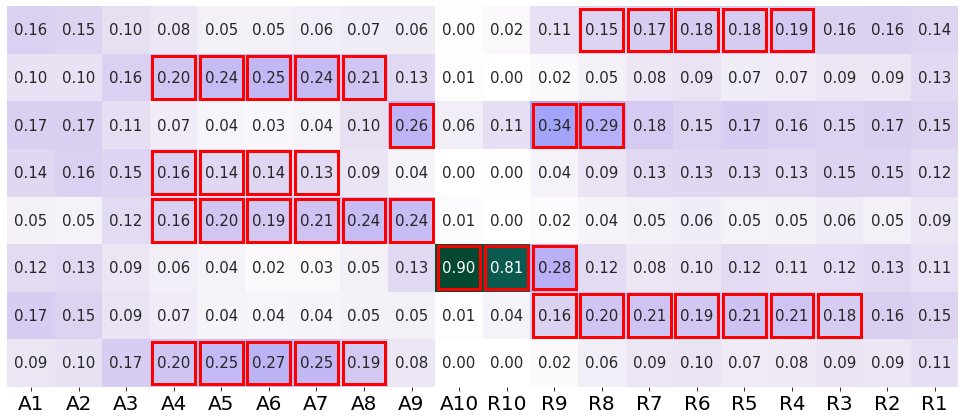

In [12]:
import cmasher as cmr

xticklabels = [None]*nprox*ndir
dir = 'AR'
for i in [0,1]:
    for j,prox in enumerate(prox_bins+[1]):
        xticklabels[(nprox*ndir-1)*i+((-1)**i)*j] = f"{dir[i]}{j+1}"

mean_P = np.nanmean(true_P,axis=0)
mean_P /= np.expand_dims(mean_P.sum(axis=0),axis=0)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7), sharex=True)
sns.heatmap(
    mean_P,
    annot=mean_P,
    fmt='.2f', annot_kws={'size': 15},
    cmap=cmr.horizon_r,#"gist_earth",
    vmin=0,vmax=1,
    ax=ax,
    cbar=False,
    square=True,
)
for i in range(pvals.shape[0]):
    for j in range(nprox*ndir):
        if pvals[i,j] < 0.05/(nprox*ndir*len(trans_list)):
            ax.add_patch(
                # patches.Circle((j+0.5,i+0.5),0.47,linewidth=2, edgecolor='red',facecolor='none')
                patches.Rectangle((j+0.05,i+0.05),width=0.9,height=0.9,linewidth=3, edgecolor='red',facecolor='none')
            )
        # elif pvals[i,j] < 0.05:
        #     ax.add_patch(
        #         # patches.Circle((j+0.5,i+0.5),0.47,linewidth=2, edgecolor='red',facecolor='none')
        #         patches.Rectangle((j+0.05,i+0.05),width=0.9,height=0.9,linewidth=3, edgecolor='orange',facecolor='none')
        #     )

# ax.set_title(r'P(State transition|Stimulus)'.format(idx_state=idx_state),fontsize=20) 
state_names = ['post-shock','shock','far','retreat','near','???']
# _ = ax.set_yticklabels([f'{state_names[int(s[0])]}$\mapsto${state_names[int(s[1])]}' for s in trans_list], fontsize=20, rotation=0)
# _ = ax.set_yticklabels([f'State{int(s[0])+1}$\mapsto$State{int(s[1])+1}' for s in trans_list], fontsize=20, rotation=0)
_ = ax.set_yticks([])
_ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
# _ = ax.set_xlabel('Stimulus category',fontsize=20)
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=15)
# cbar.ax.set_yticks(np.arange(6)/5)
# cbar.ax.set_position([0.755,0.15,0.5,0.7])
fig.savefig(f'figures/fig_P_state_trans_given_stim_K{K}_D{D}_M{M}.eps',dpi=600,bbox_inches='tight')

In [13]:
def bootstrap_err(sample):
    means = np.zeros(100)
    for i in range(100):
        means[i] = np.random.choice(sample,len(sample),replace=True).mean()
    return means.std()*1.96

def get_lb_ub(null_P):
    err_P = np.zeros_like(null_P[0])
    mean_null_P = np.zeros_like(null_P[0])
    for idx_state in range(len(trans_list)):
        for idx_stim in range(nprox * ndir):
            null_vals = null_P[:, idx_state, idx_stim]
            null_vals = null_vals[~np.isnan(null_vals)]
            err_P[idx_state, idx_stim] = bootstrap_err(null_vals)
            mean_null_P[idx_state, idx_stim] = np.mean(null_vals)
    return mean_null_P-err_P, mean_null_P+err_P

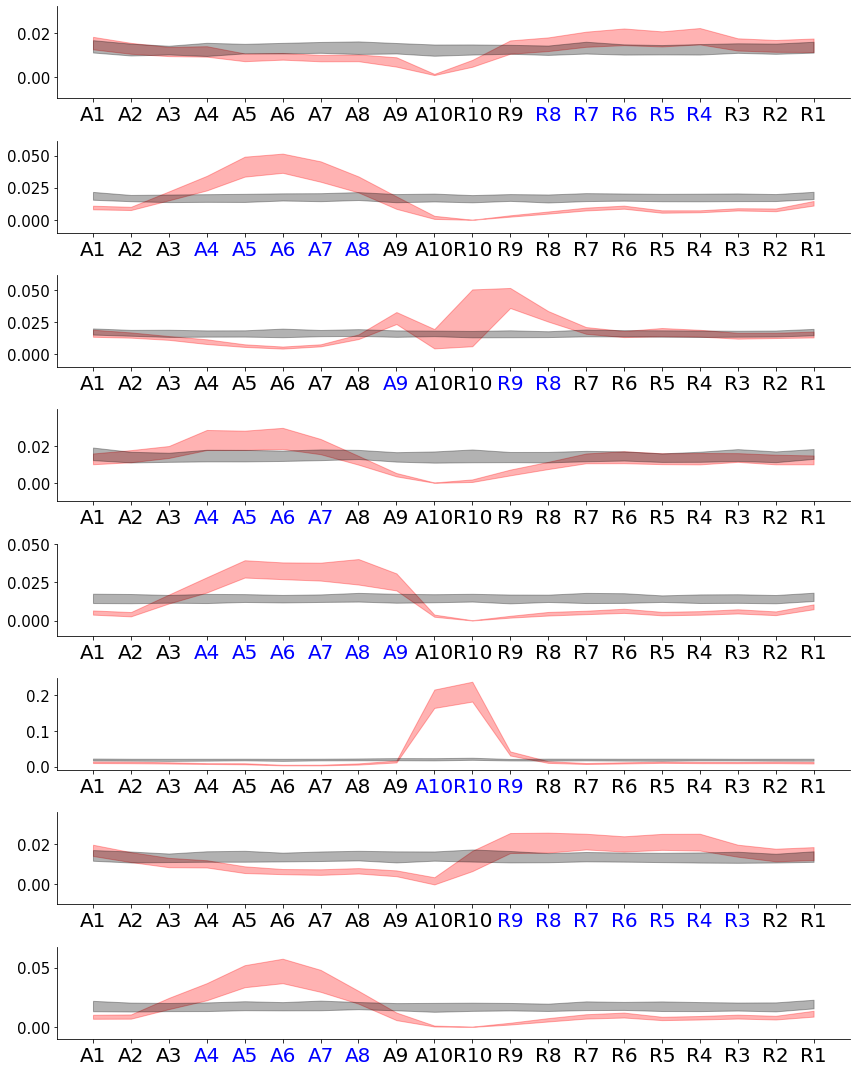

In [19]:
lb_null, ub_null = get_lb_ub(null_P)
lb_true, ub_true = get_lb_ub(true_P)

fig,axs = plt.subplots(nrows=len(trans_list), ncols=1, figsize=(12,15), sharex=False)

for idx_state in range(len(trans_list)):
    ax = axs[idx_state]
    ax.fill_between(np.arange(nprox*ndir), lb_true[idx_state], ub_true[idx_state],color='r',alpha=0.3)
    ax.fill_between(np.arange(nprox*ndir), lb_null[idx_state], ub_null[idx_state],color='k',alpha=0.3)
    _ = ax.set_xticks(np.arange(nprox*ndir))
    _ = ax.set_xticklabels(xticklabels, fontsize=20, rotation=0)
    ax.tick_params(axis='y',labelsize=15)
    ax.set_ylim([0-0.01,np.max(ub_true[idx_state]+0.01)])
    ax.spines[['right','top']].set_visible(False)
    for j in range(nprox * ndir):
        if pvals[idx_state, j] < 0.05 / (nprox * ndir * len(trans_list)):
            ax.get_xticklabels()[j].set_color("b")
    # ax.xaxis.grid(True)
    
fig.tight_layout()

fig.savefig(
    f"figures/new_fig_P_state_trans_given_stim_K{K}_D{D}_M{M}.jpg", dpi=600, bbox_inches="tight"
)

(array([1., 0., 2., 1., 8., 5., 3., 0., 0., 1.]),
 array([0.001001  , 0.00822547, 0.01544994, 0.02267441, 0.02989888,
        0.03712334, 0.04434781, 0.05157228, 0.05879675, 0.06602122,
        0.07324569]),
 <BarContainer object of 10 artists>)

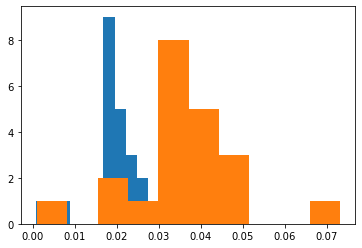

In [15]:
plt.hist(null_P[:,5,11])
plt.hist(true_P[:,5,11])



In [16]:
# for i in range(3):
#     fig = plt.figure()
#     sns.heatmap(true_count_mats[i+1],cmap='gist_earth')